<a href="https://colab.research.google.com/github/hudsonmendes/cm3070-fp/blob/mlops_google_colab/dev/mlops" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Code & Data

In this section, we load the code and the data locally, so that we can utilise  the `hlm12erc` package and use the ml pipelines as they have been designed.

The code files are copied from the following folder, and it's copied to the root directory of the present runtime.
> `/content/drive/MyDrive/Code/github/universityoflondon/cm3070-fp/*`

The following .zip file contains the data compressed, and we decompress it into the `./data` folder:
> `/content/drive/MyDrive/Datasets/meld-transformed.zip`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
if not os.path.exists("./pyproject.toml"):
  print("Source Code: overwritten!")
  !cp -R /content/drive/MyDrive/Code/github/universityoflondon/cm3070-fp/* .

if not os.path.exists("./data/"):
  print("Data: overwritten!")
  !unzip -j "/content/drive/MyDrive/Datasets/meld-transformed.zip" -d "./data/"

Source Code: overwritten!


In [4]:
!rm -rf ./data/*.csv
!unzip -j "/content/drive/MyDrive/Datasets/meld-transformerd-csvs.zip" -d "./data/"

Archive:  /content/drive/MyDrive/Datasets/meld-transformerd-csvs.zip
  inflating: ./data/sample.csv       
  inflating: ./data/test.csv         
  inflating: ./data/valid.csv        
  inflating: ./data/train.csv        


# Environment

In this section of our project, we delve into the technical groundwork, outlining the structuring of our dependencies, initializing key system configurations and paths that will be leveraged throughout the ensuing stages.

At the heart of this setup is the setup.cfg file, which lists our project's dependencies and facilitates the seamless installation of our custom-built **`hlm12erc`** library. By using the `-e` option for pip, we unlock dynamic editing capabilities for the library's codebase without requiring repeated reinstallation.

To optimise our system, we've crafted different sets of dependencies for each critical task, including `etl`, `eda`, `modelling`, `training`, and `serving`, allowing us to avoid redundant installations in environments where certain packages aren't needed. We also establish specific log levels and configure Jupyter's `auto-reload` mechanisms, empowering us with real-time updates and valuable debugging insights.

## Dependencies

In [5]:
!cat ./pyproject.toml

[build-system]
requires = ["setuptools", "wheel"]

[project]
name = "hlm12erc"
version = "0.0.1"
authors = [{ name = "Hudson Mendes", email = "hlm12@student.london.ac.uk" }]
description = "Final Project from University of London"
readme = "README.md"
license = { file = "LICENSE" }
urls = { homepage = "https://github.com/hudsonmendes/cm3070-fp" }
keywords = ["university-of-london"]
dependencies = [
    "torch >= 2.0.1",
    "torchtext >= 0.15.2",
    "torchvision >= 0.15.2",
    "transformers >= 4.30.2",
    "Pillow >= 10.0.0",
    "scikit-learn >= 1.3.0",
]

[project.optional-dependencies]
dev = ["pre-commit>=3.3.3", "black[jupyter]>=23.7.0", "isort>=5.12.0"]
test = ["pytest>=7.4.0"]
etl = [
    "kaggle>=1.5.13",
    "tqdm>=4.65.0",
    "pandas>=2.0.1",
    "google-cloud-storage>=2.10.0",
    "moviepy>=1.0.3",
]
eda = [
    "gensim",
    "tensorflow",
    "tensorflow-hub",
    "torch",
    "transformers",
    "librosa",
    "umap-learn",
    "matplotlib",
    "wordcloud",
    "pyLDAvis

In [6]:
import logging

logging.basicConfig(level=logging.INFO)

## Paths & Locations

In [7]:
import pathlib

# now that the chdir is set to the parent directory of the notebook,
# we can work as if we were running in the root directory of the repository
dir_home = pathlib.Path("./")
dir_data = dir_home / "data"
dir_target = dir_home / "target"
dir_configs = dir_home / "configs"

## TPUs for Training

For this MLOps Pipeline, we use TPUs to accelerate Machine Learning Training. The XNA dependencies are required in order to use it via PyTorch.

In [8]:
%pip install -e '.[google_colab]'

Obtaining file:///content
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl (162.9 MB)
  Building editable for hlm12erc (pyproject.toml) ... done
  Created wheel for hlm12erc: filename=hlm12erc-0.0.1-0.editable-py3-none-any.whl size=3612 sha256=0bf60809303707e413270ca1ef753445a8a313c048d847cfa9079e0d8aa00d72
  Stored in directory: /tmp/pip-ephem-wheel-cache-xtzjaim9/wheels/e8/d3/96/0e8c7135806cbda4db28d12fc8d710e5e4f66ced1411163e67
Successfully built hlm12erc
  Attempting uninstall: hlm12erc
    Found existing installation: hlm12erc 0.0.1
    Uninstalling hlm12erc-0.0.1:
      Successfully uninstalled hlm12erc-0.0.1


# Defining the Problem

Emotion Recognition in Conversations (ERC) refers to the process of recognising and analysing emotions in interactive dialogues. It presents a unique set of challenges given the fact that the same words or phrases could convey different emotions depending on the context and flow of the conversation. This task is further complicated when applied in non-dyadic settings, where multiple participants engage in a dialogue. This makes ERC a complex problem within the realm of machine learning and artificial intelligence, where context modelling and emotional shifts among interlocutors are difficult to address accurately.

Despite its complexity, ERC has garnered significant interest owing to its vast applications in opinion mining over social media threads, chat history, and other online platforms. The ability to accurately discern emotions in conversations can have profound implications for various industries, making any advancements in this field potentially groundbreaking. However, given the sparsity of the solution space and the high variability in model architecture, ERC remains a largely unexplored area with many potential paths for future research and experimentation.

## Multi-Party Setting Challenge

Multi-party conversations present an inherent set of challenges when it comes to emotion recognition (ERC). In a dialogue involving multiple participants, the context, conversation flow, and emotional shifts become considerably more intricate to decipher. The utterances in multi-party dialogues can express a wide range of emotions based on the context, making the task of accurate emotion recognition more arduous. This problem of contextual modelling and accounting for emotion shifts among multiple interlocutors remains a significant challenge in ERC. Additionally, the complex dynamics of multi-party conversations and the interdependence of individual emotional states further complicate the task.

The multi-modality of ERC data also poses another layer of challenge in multi-party settings. As emotions can only be detected through human actions such as textual utterances, visual gestures, and acoustic signals in the absence of physiological indications, the need for effectively dealing with multi-modal data becomes crucial. While some models focus on exploring this multi-modality, others resort to using a single modality, usually textual, thereby ignoring valuable insights that could be gleaned from other modalities. Consequently, the architectural variations in the existing models, coupled with the largely unexplored solution space, underscore the daunting challenges of emotion recognition in multi-party settings.

## Multi-modality Challenge

The multifaceted challenge of Emotion Recognition in Conversations (ERC) is magnified by the multi-modal nature of the data involved. ERC data typically consists of multiple modalities, such as textual utterances, visual cues, and acoustic signals. Accurately detecting emotions from these varied sources is complex, as they can individually or collectively contribute to the overall emotional context. This complexity is amplified by the high-dimensionality of the data, particularly in video and audio modalities. This high-dimensional data is both difficult to investigate and expensive to compute, posing significant challenges in data handling, processing, and analysis.

Furthermore, the computation and training of multi-modal models are exceptionally resource-intensive. Each modality may require distinct computational approaches and algorithms for processing and analyzing the data, increasing the overall computational load. Training such models also necessitates substantial computational power and time, often leading to increased costs and resource allocation. These factors, combined with the diverse architectures proposed to model ERC, contribute to the intricate and computationally demanding nature of emotion recognition. Despite the high costs and complexity, the vast potential applications of accurate ERC underscore the importance of ongoing research in this challenging, yet highly rewarding, field of machine learning.

# Assembling the Dataset

This notebook works on the **Loaded** data (already transformed through the ETL process), and unzipped in the top section of the notebook.

Here is more information about the ETL process used from the `dev/modelling.ipynb`:
> This section of the document focuses on assembling the final dataset that will be used for training and evaluating machine learning models. This involves performing ETL (Extract, Transform, Load) operations on the raw MELD data[1, 2] to prepare it for modelling. ETL is a process used to extract data from various sources, transform it into a format that is suitable for analysis, and load it into a target database or data warehouse. In this section, the raw data is extracted from various sources, transformed into a format that can be used for modelling, and loaded into a Pandas DataFrame.
>
> Here the final dataset is assembled by combining the preprocessed text, audio, and visual features for each example. The `hlm12erc` library is used to load the preprocessed features for each example and combine them into a single DataFrame. This library was created specifically for this project to simplify the notebook code by abstracting the ETL complexity into a simple, well-tested library that could be reused and scheduled if needed. The library was designed with full unit-test coverage to ensure that the data is loaded and combined correctly. The resulting DataFrame contains the preprocessed features for each example, as well as the corresponding label, which will be used for training and evaluating the machine learning models.

In [9]:
import pandas as pd

df_raw = pd.read_csv(dir_data / "train.csv", index_col=0)
df_raw

,dialogue,sequence,speaker,x_text,x_visual,x_audio,label
0,0,0,Chandler,also I was the point person on my companys tr...,d-0-seq-0.png,d-0-seq-0.wav,neutral
1,0,1,The Interviewer,You mustve had your hands full.,d-0-seq-1.png,d-0-seq-1.wav,neutral
2,0,2,Chandler,That I did. That I did.,d-0-seq-2.png,d-0-seq-2.wav,neutral
3,0,3,The Interviewer,So lets talk a little bit about your duties.,d-0-seq-3.png,d-0-seq-3.wav,neutral
4,0,4,Chandler,My duties? All right.,d-0-seq-4.png,d-0-seq-4.wav,surprise
...,...,...,...,...,...,...,...
9984,1038,13,Chandler,You or me?,d-1038-seq-13.png,d-1038-seq-13.wav,neutral
9985,1038,14,Ross,"I got it. Uh, Joey, women don't have Adam's ap...",d-1038-seq-14.png,d-1038-seq-14.wav,neutral
9986,1038,15,Joey,"You guys are messing with me, right?",d-1038-seq-15.png,d-1038-seq-15.wav,surprise
9987,1038,16,All,Yeah.,d-1038-seq-16.png,d-1038-seq-16.wav,neutral


Speaker,Text,Image,Audio,Emotion
Monica,I am not high maintenance!,,,anger
Woman,We dont have to get free stuff.,,,anger
Carol,"I don't care. I am trying to get a person out of my body here, and you're not making it any easier.",,,anger
Lydia,"Look, look at your man, Ewing. Nice shot. You know what, he couldn't hit water if he was standing on a boat.",,,disgust
Woman,"Yeah, well, now you're kinda not.",,,disgust
Larry,I wonder how long that milk has been setting out.,,,disgust
Rachel,Does it?,,,fear
Sick Bastard,Honey I swear! I wasnt looking at her!,,,fear
Ross,Just slice that baby right off!,,,fear
Chandler,Varrrrrrrrroom.,,,joy

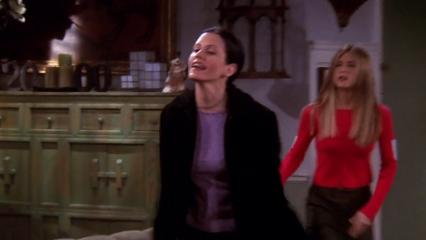
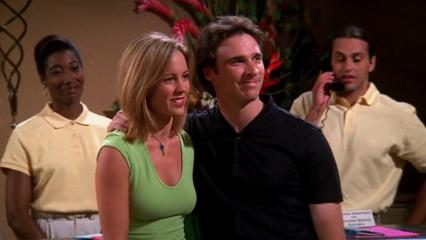
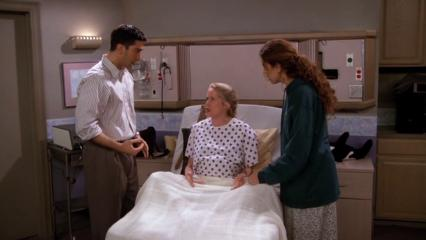
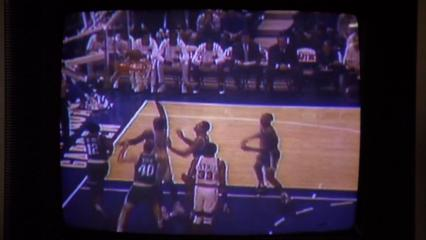
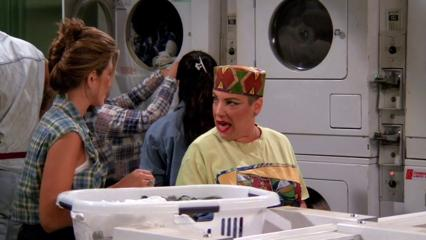
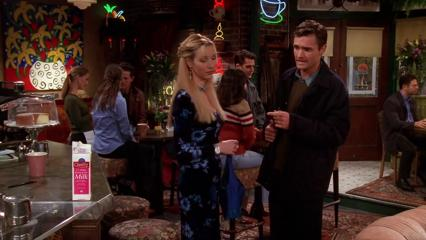
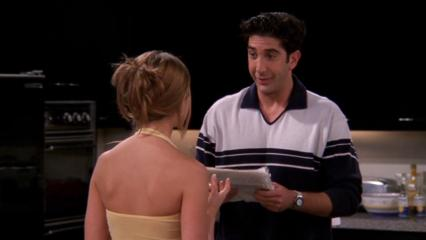
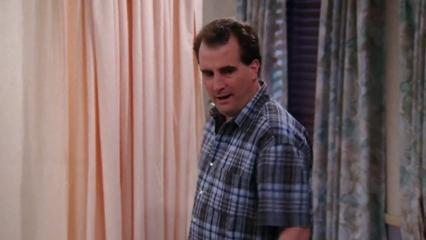
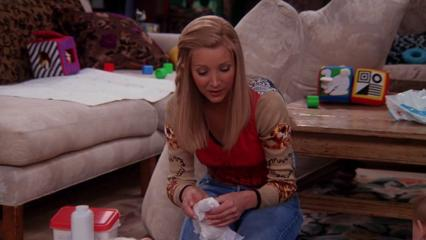
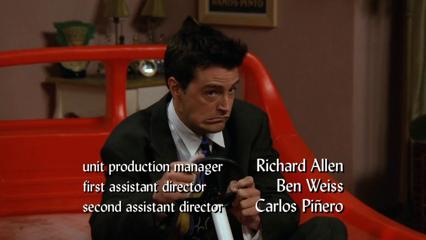
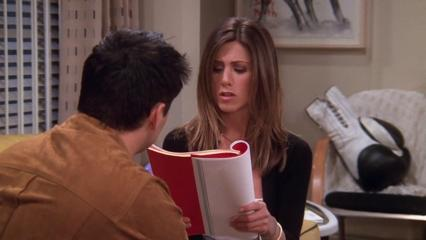
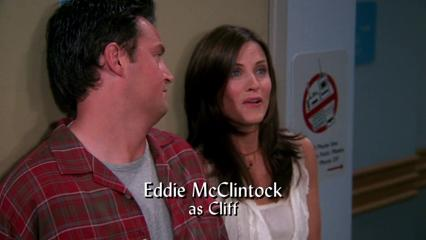
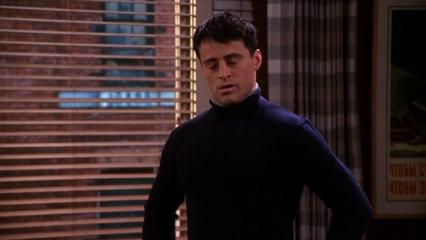
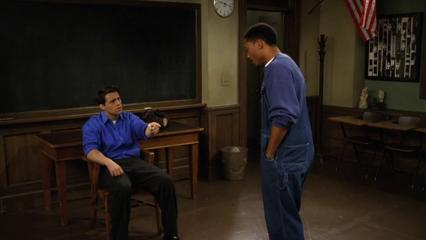
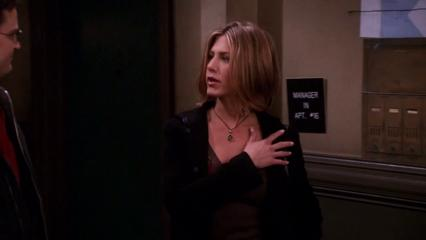
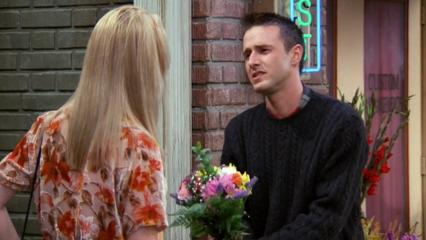
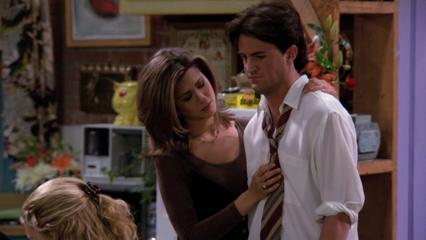
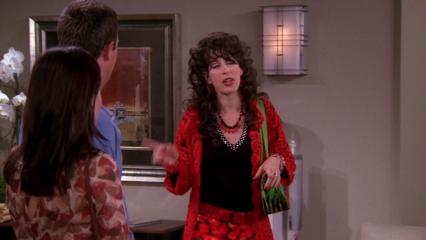
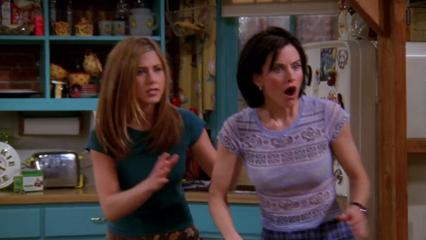
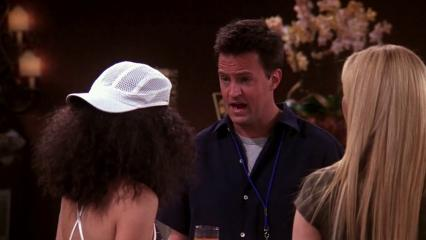
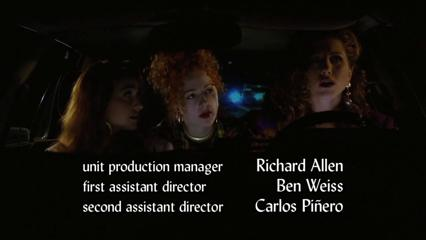

In [10]:
import os
import io
import base64
from IPython.display import display, HTML
from PIL import Image

df_sample = df_raw.groupby(["label"], group_keys=False).apply(lambda x: x.sample(min(len(x), 3)))
df_sample = df_sample.sort_values(["label"])

table_rows = []
for i, row in df_sample.iterrows():
    speaker_cell = f'<td>{row["speaker"]}</td>'
    text_cell = f'<td>{row["x_text"]}</td>'
    image_path = dir_data / row["x_visual"]
    with Image.open(image_path) as img:
        width, height = img.size
        crop_top = height // 2 - height // 10
        crop_bottom = height // 2 + height // 10
        img_cropped = img.crop((0, crop_top, width, crop_bottom))
        buffer = io.BytesIO()
        img_cropped.save(buffer, format="JPEG")
        image_data = base64.b64encode(buffer.getvalue()).decode()
    image_cell = f'<td><img src="data:image/jpeg;base64,{image_data}" width="100"></td>'
    audio_cell = f'<td><audio controls src="{os.path.join("data/", row["x_audio"])}" /></td>'
    label_cell = f'<td>{row["label"]}</td>'
    table_rows.append(f"<tr>{speaker_cell}{text_cell}{image_cell}{audio_cell}{label_cell}</tr>")

table_html = (
    "<table><tr><th>Speaker</th><th>Text</th><th>Image</th><th>Audio</th><th>Emotion</th></tr>"
    + "".join(table_rows)
    + "</table>"
)
display(HTML(table_html))

# Choosing the Metric of Success

The chosen metric of success for the **HLM12ERC** project, as outlined in the document, is **`Accuracy`**, in the form it's calculated by the `scikit-learn` library[3].

The document establishes the criteria for comparative success between different approaches, such as Advanced Textual Embeddings, based on their ability to achieve superior Accuracy scores over the MELD Test Split. This choice clearly aligns with the principles described by Francois Chollet in "Choosing the Metric of Success"[4], where the selection of a suitable metric is vital for effectively guiding the optimization of machine learning models and for a fair comparative analysis of different methods.

# Deciding on the Evaluation Protocol

The evaluation protocol for the **HLM12ERC** project adopts the **`Hold Out Test-set`** approach, a decision influenced by the structure of the MELD Dataset and the constraints imposed by its size and multimodal nature. This dataset comes pre-divided into three splits: `train`, `dev`, and `test`, which directly supports the implementation of the Hold Out approach.

The choice of this protocol is further justified due to the impracticability of using methods like K-Fold Cross Validation, stemming from the significant computational demands of the MELD dataset. In addition, the Hold Out Test-set approach serves as the evaluation standard for both individual components (Objectives 1 to 6) and the final model (Objective 7), ensuring consistent assessment throughout the development process.


# Preparing your Data

The data preparation process in this code involves three main stages: (a) ETL (Extract, Transform, Load), (b) DataSet Loading, and (c) Data Collation for model training.

* **ETL:** This stage simplifies the dataset by extracting the data from a Kaggle source, transforming it into a 1st Normal Form (1NF) CSV table format, and loading it into a destination folder or Google Cloud Storage bucket. The ETL process makes the data easier to consume by the training process. The logic can be found in the `hlm12erc.etl` module, and it can also be run with a command-line instruction, and orchestrated through the `hlm12erc.etl.ETL` class.

* **DataSet Loading:** This stage wraps the data using PyTorch Data Utility Classes to shape it appropriately for consumption by the model trainer. This step ensures that the data is organized and can be efficiently fed into the training process. The dataset class is defined at `hlm12erc.training.MeldDataset`.

* **Data Collation:** The Data Collator is responsible for creating batches of data suitable for model training and evaluation. It takes a list of MeldRecord instances and collates the data into a dictionary format with keys like `x_text`, `x_visual`, `x_audio`, and `y_true`. The collation involves converting text, visual, and audio data into appropriate formats and encoding the labels using ERCLabelEncoder, making the data ready for consumption by the PyTorch model's "forward" method during both training and inference. The collator class is defined at `hlm12erc.training.ERCDataCollator`, and can be observed below.

In [11]:
%pip install -e '.[training]'

Obtaining file:///content
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for hlm12erc (pyproject.toml) ... done
  Created wheel for hlm12erc: filename=hlm12erc-0.0.1-0.editable-py3-none-any.whl size=3612 sha256=e6462e517c2825c775a6a952739d9d4f8f7bb5162e2887b6fee02c2d99740c5d
  Stored in directory: /tmp/pip-ephem-wheel-cache-2rhor9n_/wheels/e8/d3/96/0e8c7135806cbda4db28d12fc8d710e5e4f66ced1411163e67
Successfully built hlm12erc
  Attempting uninstall: hlm12erc
    Found existing installation: hlm12erc 0.0.1
    Uninstalling hlm12erc-0.0.1:
      Successfully uninstalled hlm12erc-0.0.1


In [12]:
import inspect
from hlm12erc.training import MeldDataset
from IPython.display import Code

class_code = inspect.getsource(MeldDataset)
Code(class_code, language="python")

class MeldDataset(Dataset):
    """
    Using a dataframe to the dataset .csv file, this class allows access to
    the data in the high level form of a `MeldRecord` object, that already
    carries the visual features (PIL.Image) and audio features (wave.Wave).

    Example:
        >>> df = pd.read_csv("data/meld/train.csv")
        >>> dataset = MeldDataset(df)
        >>> record = dataset[0]
    """

    filepath: pathlib.Path
    filedir: pathlib.Path
    df: pd.DataFrame
    preprocessor_text: MeldTextPreprocessor
    preprocessor_visual: MeldVisualPreprocessor
    preprocessor_audio: MeldAudioPreprocessor

    def __init__(self, filepath: pathlib.Path, device: Optional[torch.device] = None):
        """
        Creates a new instance of the MeldDataset for a split

        :param df: The dataframe containing the data for the split
        """
        self.filepath = filepath
        self.filedir = filepath.parent
        self.df = pd.read_csv(self.filepath).sort_values(by=["dialogue", "sequence"], ascending=[True, True])
        self.preprocessor_text = MeldTextPreprocessor(df=self.df)
        self.preprocessor_visual = MeldVisualPreprocessor(device=device)
        self.preprocessor_audio = MeldAudioPreprocessor(device=device)

    def __len__(self) -> int:
        """
        Returns the number of samples in the dataset, based on the length
        of the dataframe itself.

        :return: The number of samples in the dataset
        """
        return len(self.df)

    def __getitem__(self, index) -> Union[MeldRecord, List[MeldRecord]]:
        """
        Returns a single sample from the dataset, based on the index provided.
        The sample is returned in the form of a `MeldRecord` object, that
        already carries the visual features (PIL.Image) and audio features
        (wave.Wave)

        :param index: The index of the sample to be returned, integer or slice
        :return: A `MeldRecord` instance or batch, containing the sample(s)
        """
        if isinstance(index, slice):
            batch = [self._get_single_item_at(i) for i in range(index.start, index.stop, index.step or 1)]
            batch = [item for item in batch if item]
            return batch
        else:
            return self._get_single_item_at(index)

    def _get_single_item_at(self, i: int):
        """
        Returns a single MELD Entry from position `i` in the dataset.

        :param i: The index of the sample to be returned
        :return: A `MeldRecord` object containing the sample
        """
        if i < len(self.df):
            row = self.df.iloc[i]

            with (
                Image.open(str(self.filedir / row.x_visual)) as image_file,
                wave.open(str(self.filedir / row.x_audio)) as audio_file,
            ):
                text = self.preprocessor_text(row)
                visual = self.preprocessor_visual(image_file)
                audio = self.preprocessor_audio(audio_file)
                return MeldRecord(text=text, visual=visual, audio=audio, label=row.label)
        else:
            return None

    @property
    def classes(self) -> List[str]:
        """
        Returns a list of the classes in the dataset, based on the unique
        labels in the dataframe.

        :return: A list of the classes in the dataset
        """
        return sorted(self.df.label.unique().tolist())

In [13]:
import inspect
from hlm12erc.training import ERCDataCollator
from IPython.display import Code

class_code = inspect.getsource(ERCDataCollator)
Code(class_code, language="python")

class ERCDataCollator:
    """
    Collates the data from the ERC dataset into a format that can be used and
    batched by the model, with multiple records turned into lists of its underlying
    datapoints.
    """

    LABEL_NAME: str = "y_true"

    config: ERCConfig
    label_encoder: ERCLabelEncoder
    device: Optional[torch.device]

    def __init__(
        self,
        config: ERCConfig,
        label_encoder: ERCLabelEncoder,
        device: Optional[torch.device] = None,
    ) -> None:
        """
        Initialise the ERCDataCollator class with the given ERCLabelEncoder object.

        :param config: ERCConfig object containing the configuration
        :param label_encoder: ERCLabelEncoder object containing the label encoder
        """
        self.config = config
        self.label_encoder = label_encoder
        self.device = device

    def __call__(self, batch: List[MeldRecord]) -> dict:
        """
        Collates the data from the ERC dataset into a format that can be used and
        batched by the model, with multiple records turned into lists of its underlying
        datapoints. We also encode the labels to make it easier to use in the model.

        :param record: The list of records to collate
        :return: The collated data
        """
        x_text = [r.text for r in batch]
        x_visual = self._visual_to_stacked_tensor([r.visual for r in batch])
        x_audio = self._audio_to_stacked_tensor([r.audio for r in batch])
        y_label = self.label_encoder([r.label for r in batch])
        return {
            "x_text": x_text,
            "x_visual": x_visual,
            "x_audio": x_audio,
            ERCDataCollator.LABEL_NAME: y_label,
        }

    def _visual_to_stacked_tensor(self, videos: List[torch.Tensor]) -> torch.Tensor:
        """
        Stack together tensors representing feature vectors of images.

        :param record: The list of individual tensors for visual data
        :return: The collated visual data as a tensor of shape (batch_size, *visual_in_features)
        """
        return torch.stack(videos, dim=0)

    def _audio_to_stacked_tensor(self, audios: List[torch.from_numpy]) -> torch.Tensor:
        """
        Stack together tensors of different sizes by truncating or padding them
        to the `target_size`.

        :param record: The list of individual tensors for audio data
        :return: The collated audio data as a tensor of shape (batch_size, audio_in_features)
        """

        def truncate_or_pad(vec: torch.Tensor, target_size: int) -> torch.Tensor:
            if vec.size(0) > target_size:
                return vec[:target_size]
            elif vec.size(0) < target_size:
                pad_len = target_size - vec.size(0)
                padding = torch.zeros(pad_len, *vec.size()[1:], dtype=vec.dtype)
                if self.device is not None:
                    padding = padding.to(self.device)
                return torch.cat([vec, padding], dim=0)
            else:
                return vec

        vecs = [truncate_or_pad(audio, target_size=self.config.audio_in_features) for audio in audios]
        return torch.stack(vecs, dim=0)

# Model Selection

This section takes us from a baseline model to a final model through a rigorous set of experiments set out by the **Project Design** document as objectives.

We initially attempt to establish a baseline model with some basic approaches to the representation of each modality of the data, which serves as a starting point and upon which we shall iterate.

Then, we utilize a two-step process for each different experiment to evaluate whether we can produce a better model than the ones previously devised. First, a "Scaling up" phase aims to develop a model capable of overfitting the data, allowing deeper insights into its learning capacity and identifying areas for improvement. Second, a "Regularizing" phase addresses overfitting concerns through hyperparameter tuning. This iterative optimization ultimately leads to the final model that fulfills the success criteria and delivers superior performance on the MELD Test Split.

## Training & Evaluation Utilities

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
import wandb
wandb.login()

wandb: Currently logged in as: hudsonmendes. Use `wandb login --relogin` to force relogin


True

In [16]:
%env WANDB_NOTEBOOK_NAME=google-colab.ipynb
%env WANDB_PROJECT=hlm12erc

env: WANDB_NOTEBOOK_NAME=google-colab.ipynb
env: WANDB_PROJECT=hlm12erc


In [20]:
import pathlib
from typing import Tuple
import torch_xla.core.xla_model as xm
from hlm12erc.modelling import ERCModel
from hlm12erc.training import ERCConfigLoader, ERCTrainer, MeldDataset


def train_model(
    config: str,
    batch_size: int = 32,
    n_epochs: int = 25,
    datasets: tuple = None,
) -> Tuple[str, ERCModel, pathlib.Path]:
    """
    Train a model using the given configuration file and data files.

    :param config: Path to the configuration file.
    :param batch_size: Batch size.
    :param n_epochs: Number of epochs.
    :param datasets: Tuple of train and validation dataset names, default to ("train", "valid").
    :return: Trained model.
    """

    device = xm.xla_device()
    model_config = ERCConfigLoader(dir_configs / f"{config}.yml").load()
    ds_names = datasets or ("train", "valid")
    ds_train = MeldDataset(dir_data / f"{ds_names[0]}.csv", device=device)
    ds_valid = MeldDataset(dir_data / f"{ds_names[1]}.csv", device=device)
    return ERCTrainer(model_config).train(
        data=(ds_train, ds_valid),
        batch_size=batch_size,
        n_epochs=n_epochs,
        save_to=(dir_target),
        device=device
    )

In [21]:
import pathlib

import torch
from sklearn.metrics import classification_report
from tqdm import trange

from hlm12erc.training import ERCPath, ERCDataCollator


def evaluate_model(
    model_path: pathlib.Path,
    batch_size: int,
    dataset="test",
):
    """
    Loads & runs evaluation for a model saved previously by its name, displaying
    the accuracy, F1 score and classification report.

    :param model_path: Path to the model to evaluate.
    :param batch_size: Batch size to use for evaluation.
    :param dataset: Dataset to evaluate on, one of "train", "valid" or "test".
    """
    model_instance = ERCPath(model_path).load().eval()
    ds_test = MeldDataset(dir_data / f"{dataset}.csv")
    data_collator = ERCDataCollator(label_encoder=model_instance.label_encoder)
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch_start in trange(0, len(ds_test), batch_size, desc="evaluating"):
            batch_records = ds_test[batch_start : batch_start + batch_size]
            batch_collated = data_collator(batch_records)
            y_true.extend(batch_collated["y_true"])
            y_pred.extend(model_instance(**batch_collated).labels)
        y_true_stack = torch.stack(y_true, dim=0)
        y_pred_stack = torch.stack(y_pred, dim=0)
        print(
            classification_report(
                y_true=y_true_stack.argmax(dim=1).tolist(),
                y_pred=y_pred_stack.argmax(dim=1).tolist(),
                target_names=model_instance.label_encoder.classes,
            )
        )

## Training Mock Run

To avoid spending resources on broken/buggy code, we training, validation and evaluation on a sample (small) dataset, with few epochs.



In [ ]:
mock_model_name, mock_model_instance = train_model("sample", n_epochs=1, batch_size=4, datasets=("sample", "sample"))
evaluate_model(dir_target / mock_model_name, batch_size=4, dataset="sample")

## Objective 1: Baseline Model

In [ ]:
baseline_model_name, baseline_model_instance = train_model("baseline", n_epochs=15, batch_size=32)
evaluate_model(dir_target / baseline_model_name, batch_size=32)